# Analiza pasemskih mačk

In [9]:
import pandas as pd
import os.path
import re
from statistics import mean

# pd.options.display.max_rows = 10
%matplotlib notebook

# naložimo razpredelnico, s katero bomo delali
pot_do_mack = os.path.join("pasme_mack.csv")
macke = pd.read_csv(pot_do_mack)

In [10]:
#Life expectancy
a = []
for el in macke['Life expectancy']:
    if type(el) == str:
        a.append([int(i) for i in re.findall(r"[\d']+", el)])
    else:
        a.append(el)
macke['Life expectancy'] = a
a


[[13, 15],
 [15, 18],
 [13, 15],
 [13, 15],
 [14, 18],
 [15, 20],
 [10, 16],
 [12, 15],
 [12, 15],
 [14, 18],
 [14, 18],
 [13, 15],
 [12, 15],
 [15, 20],
 [12, 15],
 [14, 16],
 [13, 15],
 [12, 14],
 [12, 18],
 [12, 15],
 [15],
 [12, 16],
 [13, 17],
 [12, 15],
 [14, 18],
 [12],
 [12, 15],
 [9, 14],
 [15, 20],
 [13, 15],
 [10, 15],
 [14, 16],
 [10, 20],
 [10, 15],
 [15, 20],
 [15, 20],
 [11, 13],
 [15],
 [13, 20],
 [15, 19],
 [14, 16],
 [12, 15],
 [10, 20],
 [12, 15],
 [10, 13],
 [12, 20],
 [12, 16],
 [12, 15],
 [13, 20],
 [15],
 [13, 20],
 [12, 15],
 [12, 20],
 [15, 20],
 [15, 20],
 [10, 20],
 [12, 15],
 [12, 15],
 [13, 15],
 [8, 20],
 [12, 20],
 [12, 15],
 [13, 15],
 [12, 15],
 [15, 18],
 [14, 19],
 [15, 20]]

TypeError: 'float' object is not iterable

In [11]:
macke

,Breed,Life expectancy,Temperament,Type of coat,Price,Female cat in,Male cat in,Female cat lb,Male cat lb,Affectionate,...,Chatty,Need for exercise / Sporty,Tendency to run away,Greedy / Gluttony,Breed and cats,Breed and dogs,Breed and children,Breed and the elderly,Strong / robust,Tendency to put on weight
0,abyssinian-cat,"[13, 15]","['Affectionate', 'Playful', 'Intelligent']",['Short'],[300],[12],[12],"[7, 9]","[9, 11]",3,...,2,3,2,3,2,3,2,1,2,2
1,american-bobtail,"[15, 18]","['Affectionate', 'Intelligent']",['Short'],"[450, 750]","[14, 16]","[14, 16]","[11, 18]","[13, 20]",3,...,1,2,2,2,2,3,3,2,3,2
2,american-curl,"[13, 15]","['Affectionate', 'Playful', 'Intelligent']","['Short', 'Long']","[600, 900]","[12, 14]","[12, 16]","[4, 7]","[7, 11]",3,...,1,3,3,3,2,3,3,2,2,3
3,american-shorthair,"[13, 15]","['Affectionate', 'Intelligent']",['Short'],NaN,"[12, 14]","[12, 14]","[7, 11]","[9, 15]",3,...,1,2,2,2,3,3,3,3,3,3
4,american-wirehair,"[14, 18]","['Affectionate', 'Intelligent']",['Short'],"[760, 910]","[12, 14]","[12, 14]","[7, 11]","[9, 15]",3,...,1,2,2,2,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,tonkinese,"[13, 15]","['Affectionate', 'Playful', 'Intelligent']","['Short', 'Long']","[300, 700]","[10, 12]","[12, 14]","[4, 9]","[11, 13]",3,...,2,3,2,3,2,3,3,1,2,1
63,toyger,"[12, 15]","['Affectionate', 'Intelligent']",['Short'],"[600, 1500]","[12, 14]","[12, 14]","[7, 11]","[9, 15]",3,...,2,2,2,2,3,3,3,2,2,2
64,turkish-angora,"[15, 18]","['Affectionate', 'Playful', 'Intelligent']",['Long'],"[150, 200]","[12, 13]","[12, 13]","[4, 11]","[4, 11]",3,...,3,3,2,2,3,3,3,2,3,1
65,turkish-van,"[14, 19]","['Affectionate', 'Playful', 'Intelligent']",['Long'],"[300, 460]","[10, 12]","[10, 12]","[11, 13]","[11, 20]",3,...,3,3,2,3,2,2,3,1,3,2


TypeError: can't convert type 'str' to numerator/denominator

## Grafi

<IPython.core.display.Javascript object>


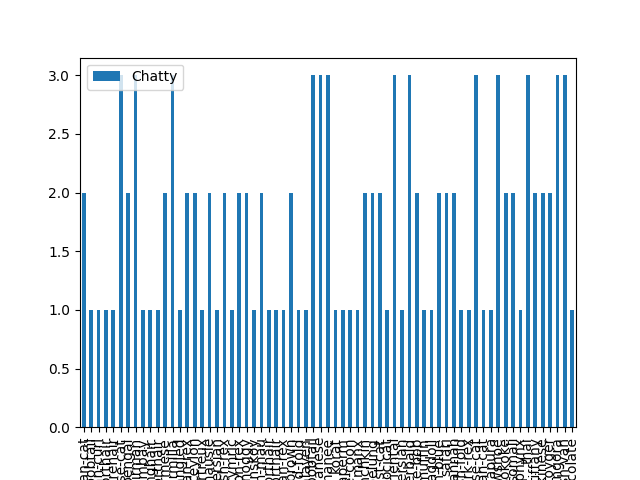

<AxesSubplot:xlabel='Breed'>

In [9]:
m = macke.head(10)
m.plot.bar(x = 'Breed', y = 'Chatty')

#### Breed and children vs playful vs chatty

<IPython.core.display.Javascript object>


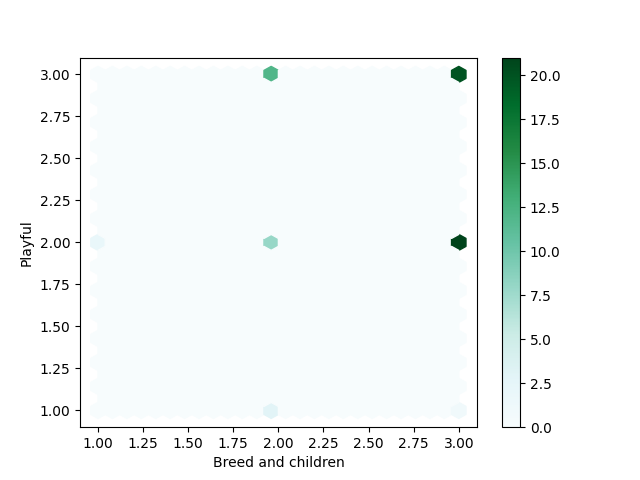

<AxesSubplot:xlabel='Breed and children', ylabel='Playful'>

In [16]:
macke.plot.hexbin('Breed and children', 'Playful',gridsize=25)

#### Type of coat vs price

#### Average female cat in vs average male cat in

#### Life expectancy vs mean(inteligent, independent, strong)

In [29]:
povprecje = (macke['Intelligent'] + macke['Strong / robust'] + macke['Independent'])/3
povprecje


0     2.333333
1     2.333333
2     2.333333
3     2.666667
4     2.666667
        ...   
62    2.333333
63    2.333333
64    2.333333
65    2.666667
66    2.000000
Length: 67, dtype: float64

#### Tendency to put on weight vs average female cat lb and average male cat lb

In [20]:
#Female cat lb
a = []
for el in macke['Female cat lb']:
    a.append([int(i) for i in re.findall(r"[\d']+", el)])
macke['Female cat lb'] = a

#Male cat lb
a = []
for el in macke['Male cat lb']:
    a.append([int(i) for i in re.findall(r"[\d']+", el)])
macke['Male cat lb'] = a

TypeError: expected string or bytes-like object

In [26]:
cumsum(macke['Intelligent'], macke['Chatty'])

NameError: name 'cumsum' is not defined